In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [14]:
# read data from Data+_2025/data/enrollment_projections/sgr_table_region_2324_20240710.xlsx in Google Drive
sgr_data = pd.read_excel(r'/Users/leahwallihan/Durham_school_planning/sgr_htype_region.xlsx')

In [16]:
# remove null values and shorten to only use relevant columns
sgr_data = sgr_data.dropna()
sgr_data.rename(columns={'sgr_dps_2324_all.1': 'sgr_dps_avg_k12'}, inplace=True) # because there might be a typo in the file?
sgr_data = sgr_data[['housing_type','region','sgr_dps_avg_k12']]
sgr_data['sgr_dps_avg_k12'] = sgr_data['sgr_dps_avg_k12'].round(4)
sgr_data.set_index(['region', 'housing_type'], inplace=True)

In [18]:
# read in shapefile to get geometries for HS regions from Data+_2025/QGIS/DPS shapefiles from layers in Google Drive
regions = gpd.read_file(r'/Users/leahwallihan/Durham_school_planning/geospatial files/HS_regions')[['region', 'geometry']]
regions = regions.to_crs('EPSG:4326')
#read in geojson with residential developments
res_dev = gpd.read_file(r'/Users/leahwallihan/Durham_school_planning/DPS-Planning/GIS_files/resdev_cases.geojson')
res_dev = res_dev.to_crs('EPSG:4326')

In [20]:
# function to count number of students in each row
def count_students(row): 
        
    htype_map = {
        'sf_detached': 'sf_detach',
        'sf_attached': 'sf_attach',
        'duplex/triplex': 'du_tri',
        'multifamily': 'mf_apt',
        'condo': 'condo'
    }

    region = row['region']

    total = 0
    for col_name, sgr_col in htype_map.items():
        count = row.get(col_name, 0)

        try:
            multiplier = sgr_data.loc[(region, sgr_col), 'sgr_dps_avg_k12']
        except KeyError:
            multiplier = 0

        total += count * multiplier

    return total

In [22]:
res_dev['student_gen'] = res_dev.apply(count_students, axis=1)

In [24]:
# gets counts for each region
region_gen = res_dev.groupby('region')['student_gen'].sum()
regions.set_index('region', inplace=True)
regions['student_gen'] = region_gen

In [ ]:
#regions.to_file('region_gen.geojson', driver='GeoJSON')

In [ ]:
#res_dev.to_file('resdev_with_stu_proj.geojson', driver='GeoJSON')

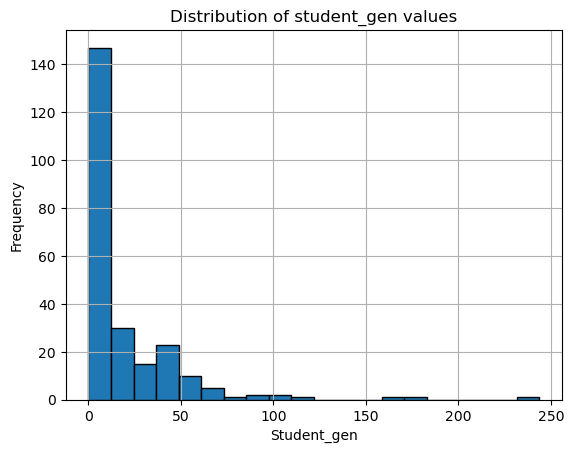

In [26]:
#res_dev["student_gen"].max()

res_dev["student_gen"].plot.hist(bins=20, edgecolor='black')

plt.xlabel("Student_gen")
plt.ylabel("Frequency")
plt.title("Distribution of student_gen values")
plt.grid(True)

plt.show()

In [28]:
# read in planning unit shapefile 
pu = gpd.read_file('/Users/leahwallihan/Durham_school_planning/geospatial files/pu_shape.geojson')